[ 프로젝트 : mini BERT 만들기 ]

[1] 학습 목표
- BERT 모델을 구현하고 훈련시킬 수 있다.
- BERT에 사용된 masking 기법들을 이해하고 구현할 수 있다.
- NSP task를 이해하고, 데이터셋을 이에 맞게 구성할 수 있다.


[2] 프로젝트 절차
1. Tokenizer 준비
SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

2. 데이터 전처리 (1) MASK 생성
BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

3. 데이터 전처리 (2) NSP pair 생성
BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.

두 문장 사이에 segment 처리를 해주세요. 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

4. 데이터 전처리 (3) 데이터셋 완성
BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

5. BERT 모델 구현
pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

6. pretrain 진행
loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.

7. 프로젝트 결과
학습된 모델과 학습과정을 시각화해 보세요. NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.

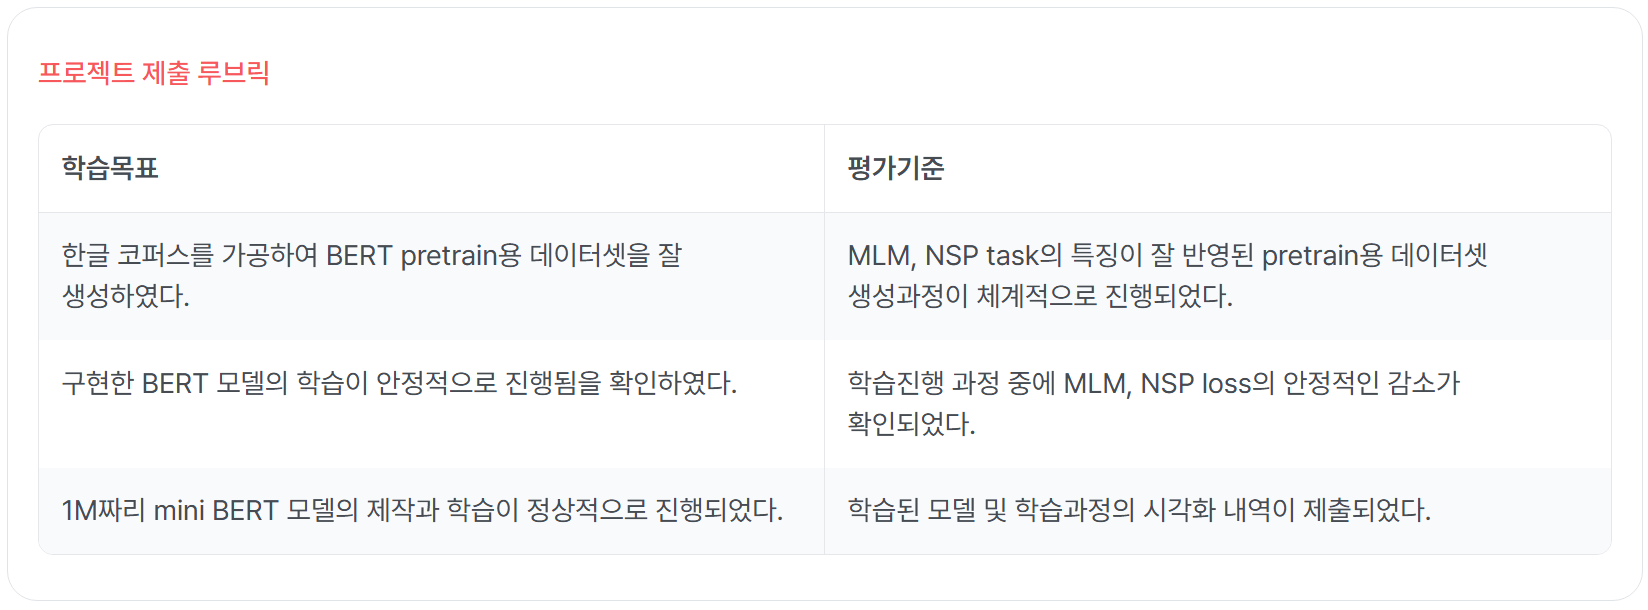

# 요약

테스트는 순차적으로 feed forward 크기, 헤드 크기(d_head: 64->32), 레이어수(num_hidden layers: 3 ->2) 등 세가지 항목을 줄여보았다. 
테스트 결과 파라미터 수는 베이스모델 186만개에서 최종적으로 100만개 이하인 93만개로  줄어들었다. 각각의 파라미터 수를 보면, feed forward크기(d_ff: 1024->256)를 줄인 경우 126만 개로 줄었고, 헤드 크기를 줄인 경우 107만개로 줄었으며, 레이어수(num_hidden layers: 3 ->2)를 줄인 경우 93만개로 줄었다.

성능은 베이스 모델에서 최종적으로 loss(8.3->8.29), NSP loss(0.65->0.64), MLM loss(7.64->7.64), NSP Accuracy(0.62->0.63), MLM Accuracy(0.86 ->0.86)로 나옴으로써 전체적이 성능이 아주 미세하게 향상되거나 변화하지 않았다.

마지막으로 부분 데이터(128000건)에서 전체 데이터로 바꿔서 모델을 돌린 결과 loss(8.3->8.21), NSP loss(0.65->0.58), MLM loss(7.64->7.63), NSP Accuracy(0.62->0.77), MLM Accuracy(0.86 ->0.88)로 전체적으로 성능이 아주 미세하게 향상되었다.

작고 가벼운 모델을 만들기 위해 데이터에 맞춰 모델의 각 파라미터의 적절한 수를 찾는 것의 중요성을 확인하였다.

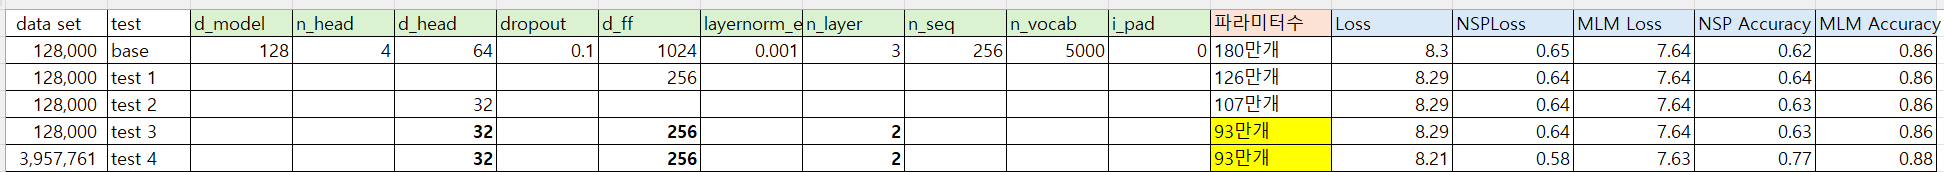

### 라이브러리 설치

In [ ]:
# 토큰화 라이브러
!pip install sentencepiece
!pip install tqdm
!conda install -y -c conda-forge ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install torchsummary

# 모델 생성을 위한 라이브러리 설치
!pip install torchinfo

### 라이브러리 임포트

In [2]:
# 라이브러리 버전 확인

import torch
import numpy
import pandas
import matplotlib
import json
import re

print(torch.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)


# 데이터 전처리
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

# pretrain_시각화
import matplotlib.pyplot as plt



2.7.1+cu118
2.2.6
2.3.0
3.10.3
2.0.9
2.2.1


# 0. 데이터 준비

### 로컬환경에서 데이터 다운로드

In [2]:
#로컬에서 진행하실 경우 다음과 같이 경로설정을 합니다  
#!mkdir data
#!mkdir models
#!wget https://d3s0tskafalll9.cloudfront.net/media/documents/kowiki.txt.zip
#!mv kowiki.txt.zip /content/data
#%cd /content/data
#!unzip kowiki.txt.zip

# 1. Tokenizer 준비
SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

In [3]:
#  한글 나무위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 생성

$ python
>>> import sentencepiece as spm
>>> import os
>>> corpus_file = os.getenv('HOME')+'/work/bert_pretrain/data/kowiki.txt'
>>> prefix = os.getenv('HOME')+'/work/bert_pretrain/models/ko_32000'
>>> vocab_size = 8000
>>> spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

SyntaxError: invalid syntax (634409441.py, line 3)

In [3]:
# sentencepiece 모델 학습이 끝난 후 생성된 ko_8000.model, ko_8000.vocab 두 파일 불러오기

import sentencepiece as spm
import os
corpus_file = '/home/jovyan/work/bert_pretrain/data/kowiki.txt'
prefix = '/home/jovyan/work/bert_pretrain/data/ko_8000'
vocab_size = 8000
#센텐스피스를 직접 만들어보실 분들은 주석을 풀어 진행해보세요! 
#(LMS 환경에서는 시간이 오래 걸려요)
#spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

In [4]:
# sentencepiece 모델 학습이 끝난 후 생성된 ko_8000.model, ko_8000.vocab 두 파일 불러오기
data_dir = '/home/jovyan/work/bert_pretrain/data/'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{data_dir}/ko_8000.model")


True

In [5]:
# [토크나이저 모델 생성시] 토크나이저가 잘 만들어졌는지 확인
#Q. 특수 token 7개를 제외한 나머지 token들을 출력해봅시다.
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))
print(vocab_list)

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바', '까지', '▁무', '▁남', '▁통', '▁현', '▁교', '▁같', '에게', '▁내', '학교', '▁문', '▁출', '▁거', '▁포', '▁결', '된다', '▁《', '적인', '이라', '▁6', '▁우', '적으로', '▁불', '▁원', '▁최', '▁10', '▁진', '▁생', '▁작', '▁어', '▁당', '국의', '▁노', '▁강', '▁알', '▁반', '▁7', '▁8', '▁계', '▁따', '▁파', '▁분', '▁없', '▁받', '▁말', '면서', '들이', 'or', '되었', '▁사용', "▁'", '▁두', '▁실', '에서는', '▁리', '들은', '▁명', '▁함', '▁단', '▁이후', '00', '하기', '▁예', '년에', '),',

In [6]:
# 토크나이저가 잘 작동하는지 예문으로 확인
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


# 2. 데이터 전처리 

## 2-1. [데이터 전처리] (1) MASK 생성
BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용하세요.

BERT의 Masked Language Model(MLM)은 GPT의 Next Token Prediction 태스크처럼 다음이 이어질 단어는? 을 맞추는 게 아니라 마스킹 된 다음 빈칸에 알맞은 단어는? 문제를 푸는 형식으로 구성됩니다.

MLM을 위해 BERT는 학습 데이터의 전체에서 15%를 [MASK] 토큰으로 랜덤하게 바꿉니다. 이 15%의 [MASK] 토큰 중 80%는 [MASK] 토큰, 10%는 무작위로 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용합니다.

이전 스텝의 Masked LM 데이터셋 예시에서 출발해 봅시다.

In [7]:
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


14

15%를 마스킹 한다고 해도 생각해 볼 것이 더 있습니다. Subword 기반으로 토크나이징을 했을 때 _대, [MASK], 민국이라고 가운데를 마스킹 했을 경우 해당 [MASK]가 '한'일 거라는 건 너무 쉽게 맞출 수 있습니다. '대한민국'이라는 패턴을 아주 자주 보게 될 테니까요.

그래서 Masked LM 태스크를 구성할 땐 띄어쓰기 단위로 한꺼번에 마스킹해 주는 것이 좋습니다. 다음과 같이 처리합니다.

In [8]:
# 띄어쓰기 단위로 mask하기 위해서 index 분할
cand_idx = []  # word 단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# 결과확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5, 6] ['▁비', '가']
[7, 8] ['▁내', '리는']
[9, 10, 11] ['▁날', '이었', '어']
[12, 13, 14] ['▁그', '날', '은']
[15, 16, 17] ['▁', '왠', '지']
[18, 19, 20] ['▁손', '님', '이']
[21, 22] ['▁많', '아']
[23] ['▁첫']
[24, 25] ['▁번', '에']
[26, 27] ['▁삼', '십']
[28] ['▁전']
[29, 30, 31] ['▁둘', '째', '번']
[32, 33] ['▁오', '십']
[34] ['▁전']
[35, 36, 37] ['▁오', '랜', '만에']
[38, 39, 40] ['▁받아', '보', '는']
[41] ['▁십']
[42, 43, 44] ['▁전', '짜', '리']
[45, 46, 47] ['▁백', '통', '화']
[48, 49, 50] ['▁서', '푼', '에']
[52, 53, 54] ['▁손', '바', '닥']
[55, 56] ['▁위', '엔']
[57, 58, 59] ['▁기', '쁨', '의']
[60, 61] ['▁눈', '물이']
[62, 63] ['▁흘', '러']
[64, 65, 66] ['▁컬', '컬', '한']
[67, 68] ['▁목', '에']
[69, 70] ['▁모', '주']
[71, 72, 73] ['▁한', '잔', '을']
[74, 75] ['▁적', '셔']
[76] ['▁몇']
[77] ['▁달']
[78] ['▁포']
[79, 80] ['▁전', '부터']
[81, 82, 83, 84] ['▁콜', '록', '거', '리는']
[85] ['▁아내']
[86, 87] ['▁생각', '에']
[88, 89, 90] ['▁그', '토', '록']
[91, 92] ['▁먹', '고']
[93, 94, 95] ['▁싶', '다', '던']


In [9]:
# random mask를 위해서 index 순서를 섞음
random.shuffle(cand_idx)
cand_idx

[[24, 25],
 [57, 58, 59],
 [32, 33],
 [64, 65, 66],
 [41],
 [79, 80],
 [52, 53, 54],
 [67, 68],
 [29, 30, 31],
 [91, 92],
 [23],
 [26, 27],
 [76],
 [42, 43, 44],
 [78],
 [60, 61],
 [38, 39, 40],
 [93, 94, 95],
 [9, 10, 11],
 [81, 82, 83, 84],
 [85],
 [12, 13, 14],
 [34],
 [71, 72, 73],
 [77],
 [45, 46, 47],
 [48, 49, 50],
 [28],
 [74, 75],
 [62, 63],
 [88, 89, 90],
 [5, 6],
 [35, 36, 37],
 [55, 56],
 [18, 19, 20],
 [86, 87],
 [7, 8],
 [15, 16, 17],
 [1, 2, 3, 4],
 [21, 22],
 [69, 70]]

In [10]:
# 개선된 Masking 로직을 다음과 같이 구현해 보았습니다. 마스킹 된 결과를 이전과 비교해 보시죠.

# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask 된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    dice = random.random()  # 0과 1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '프', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에'

In [11]:
# Masked LM의 라벨 데이터도 아래와 같이 생성하여 정리해 둡니다.

# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

mask_idx   : [23, 24, 25, 32, 33, 41, 57, 58, 59, 64, 65, 66, 79, 80]
mask_label : ['▁첫', '▁번', '에', '▁오', '십', '▁십', '▁기', '쁨', '의', '▁컬', '컬', '한', '▁전', '부터']


###  create_pretrain_mask() : Masked LM을 위한 코퍼스 생성 메소드
이번 스텝에서 구현할 최종 메소드는 아래와 같습니다.

In [12]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [13]:
# create_pretrain_mask() 수행 결과를 다시 한번 확인
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '[MASK]', '[MASK]', '[MASK]', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '팹', '著', '內', '[SEP]', '▁손', '바', '닥', '[MASK]', '[MASK]', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '[MASK]', '[MASK]', '▁한', 

## 2-2.  [데이터 전처리] (2) NSP pair 생성
BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.

두 문장 사이에 segment 처리를 해주세요. 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.

BERT의 pretrain task로 Next Sentence Prediction이 있습니다. 문장 2개를 붙여 놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞출 수 있게 하는 것입니다.

아래와 같이 문장 A의 다음 문장이 B일 경우는 TRUE, 아니면 FALSE로 예측하게 합니다.

In [14]:
# 아래 문장을 예시로 진행해 보겠습니다.
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [15]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

In [16]:
# 우선 원문에서 이어진 두 문장씩 짝지어 보겠습니다.

# 이 단계에서 넣어줄 특수 token은 [CLS]와 [SEP]이고, sequence의 최대 길이는 n_test_seq - 3으로 정합니다.

# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [17]:
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다.
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
tokens_a: 50 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에']
tokens_b: 12 ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '

짝지은 두 문장을 그대로 두면 NSP task의 true label 케이스가 되고, 둘의 순서를 뒤바꾸면 false label 케이스가 되겠죠?

두 문장의 최대 길이를 유지하도록 trim을 적용한 후 50%의 확률로 true/false 케이스를 생성해 보겠습니다.

token A의 길이가 max_seq보다 길면 앞에서부터 토큰을 제거하고, token B의 길이가 길면 뒤에서부터 토큰을 제거합니다.

In [18]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [19]:
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0     #False
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1    #True
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 28 ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 33 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

이제 두 문장 사이에 segment 처리를 해주어야 합니다. 첫 번째 문장의 segment는 모두 0으로, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주는 것으로 마무리됩니다.

이전 스텝의 create_pretrain_mask()까지 함께 호출되어 Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋으로 완성될 것입니다. BERT의 pretrain은 MLM과 NSP, 두 가지 task가 동시에 수행되니까요.

In [20]:
instances = []
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0    # False
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1   # True
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################

        # tokens & segment 생성
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)

        # mask
        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)

        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 12 ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 49 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼']
tokens: 64 ['[CLS]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘'

In [21]:
# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '[MASK]', '[MASK]', '[MASK]', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '▁번', '에', '▁삼', '십', '가로', '[MASK]', '[MASK]', '▁번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [25, 26, 27, 36, 41, 42, 43, 45, 46], 'mask_label': ['▁그', '날', '은', '▁첫', '▁전', '▁둘', '째', '▁오', '십']}
{'tokens': ['[CLS]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '暴', '°', '[SEP]', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '

### 🔶 create_pretrain_instances() : Next Sentence Prediction을 위한 코퍼스 생성 메소드

In [22]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):

        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [23]:
# create_pretrain_instances() 수행 결과를 다시 한번 확인

instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁번', '에', '▁삼', '십', '[MASK]', '▁둘', '째', 'え', '▁오', '십', '▁전', '▁오', '랜', '만에', '[MASK]', '[MASK]', '[MASK]', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [5, 8, 15, 16, 17, 36, 37, 38, 39], 'mask_label': ['▁전', '▁번', '▁받아', '보', '는', '▁눈', '물이', '▁흘', '러']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁몇', '▁달', '[MASK]', '▁전', '부터', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '[MASK]', '▁수', '▁있어', '▁집', '

## 2-3. [데이터 전처리] (3) 데이터셋 완성
BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화해 보세요.

### 이제 우리가 다루어야 할 kowiki.txt에 대해 본격적으로 들여다보겠습니다

In [24]:
corpus_file = '/home/jovyan/work/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

위키 문서는 하나의 도큐먼트가 주제 키워드에 대해 상세 내용이 설명으로 따라붙어 있는 형태로 구성되어 있지요? 도큐먼트 주제별로 잘 나눠지는지도 확인해 보겠습니다.

In [25]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # 빈 줄이 아니면 doc에 저장
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지', '미', '▁카', '터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니어', '(,', '▁192', '4', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인', '권', '과', '▁중', '재', '▁역할', '에', '▁대한', '▁공', '로를', '▁인정', '받아', '▁노', '벨', '▁평화', '상을', '▁받', '게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념', '을', '▁다루', '는', '▁학', '문', '이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용', '해서', '▁공', '리로', '▁구성된', '▁추', '상', '적', '▁구조를', '▁연구', '하는', '▁학', '문', '으로', '▁여겨', '지', '기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조', '와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학', '문', '들과', '▁깊', '은', '▁연', '관을', '▁맺', '고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학', '의', '▁분야', '들과', '는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지',

### 이전 스텝에서 완성했던 create_pretrain_instances()를 코퍼스에 적용할 수 있는지 몇 라인에 대해서만 확인해 봅시다

In [26]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁고', '분', '자', '물', '질', '▁등', '도', '▁유', '기', '화', '학', '에서', '▁다루', '어진', '다', '.', '[SEP]', '▁유', '기', '화', '학', '은', '▁탄', '소로', '▁이루어진', '[MASK]', '[MASK]', '[MASK]', '▁연구', '하는', '▁분', '과', '이다', '.', '▁원래', '▁유', '기', '▁화', '합', '물', '은', '▁식물', '이나', '▁동물', '로부터', '▁추', '출', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [10, 11, 12, 13, 14, 15, 41, 42, 43], 'mask_label': ['▁합', '성', '섬', '유', '등', '의', '▁화', '합', '물을']}
{'tokens': ['[CLS]', '으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '▁합', '성', '섬', '유', '등', '의', '▁고', '분', '자', '물', '질', '▁등', '도', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁다루', '어진', '다', '.', '[SEP

### 🔶 make_pretrain_data() : BERT pretrain 데이터셋 생성 메소드

In [28]:
# 전체 전처리 과정을 거쳐 최종적으로 만들어지는 BERT pretrain 데이터셋 생성 메소드는 다음과 같습니다.
# Q. 아래 주석에 따라 코드를 완성해주세요.
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

이제 약 400만 라인에 해당하는 전체 코퍼스에 대해 make_pretrain_data()를 구동해 봅시다. 10여 분 가량 시간이 소요될 수 있습니다.

최종적으로 생성된 데이터셋은 json 포맷으로 저장될 것입니다.

In [29]:
pretrain_json_path = '/home/jovyan/work/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)


  0%|          | 0/3957761 [00:00<?, ?it/s]

In [30]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918189

데이터셋 파일을 만드는 것까지 수행되었습니다.

하지만 여기서 고려해야 할 점이 있습니다. 우리가 다루어야 할 데이터셋은 사이즈가 큽니다. 만들어질 json 데이터파일의 크기가 1.4GB 정도 됩니다. 실제 BERT 학습용의 백 분의 일 사이즈 정도밖에 안 되겠지만 그럼에도 불구하고 이렇게 큰 파일을 로딩하는 함수를 만들 때는 메모리 사용량과 관련해 고려해야 할 점이 있습니다.

그래서 우리는 np.memmap을 사용해서 메모리 사용량을 최소화하는 방법을 시도해 볼 것입니다

In [31]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [32]:
# 만들어진 json 파일을 라인 단위로 읽어 들여 np.memmap에 로딩해 봅시다.

# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=int)
        label_mlm = np.full(n_seq, dtype=int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 0/918189 [00:00<?, ?it/s]

{'tokens': ['[CLS]', '일', '▁~', '[MASK]', '[MASK]', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '[MASK]', '▁1981', '년', ')', '이다', '.', '▁지', '미', '▁카', '터', '는', '[MASK]', '[MASK]', '[MASK]', '▁섬', '터', '▁카운', '티', '▁플', '레', '인', '스', '▁마을', '에서', '▁태어났다', '.', '▁조지', '아', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '▁후', '▁해', '군에', '▁들어가', '▁전', '함', '·', '원', '자', '력', '·', '잠', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁195', '3', '년', '▁미국', '▁해군', '▁대', '위로', '▁예', '편', '하였고', '▁이후', '▁땅', '콩', '·', '면', '화', '[MASK]', '▁가', '꿔', '▁많은', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁그의', '▁별', '명이', '▁"', '땅', '콩', '▁농', '부', '"', '▁(', 'P', 'e', 'an', 'ut', '▁F', 'ar', 'm', 'er', ')', '로', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁지', '미', '▁카', '터', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### 🔶 load_pre_train_data() : 학습에 필요한 데이터를 로딩하는 함수
np.memmap을 사용해 메모리 효율적으로 만들어진 데이터를 로딩하는 함수를 아래와 같이 구성하였습니다.

In [33]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [34]:
# 우선 128000 건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

data load early stop 128000 128000


In [35]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5, 3629,  203,    6,    6, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1647, 3682, 3682, 3625,    6, 3008, 3625, 3616,   16,
         3599,   18, 3686,  207, 3714, 3602,    6,    6,    6,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1509,  168, 3877,  414,  165, 1697, 4290, 3873,
         3703, 3683,    6,   21, 5007,  399,    6,    6,    6,    6,    6,
          307,  587,  931,  103, 4313, 4290,  613, 3638, 3718,   98, 3878,
         3656,  256, 2543,  309,  337, 3735,  181, 3616, 3603,    6,    6,
            6,    4,   18, 3686,  207, 3714,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

# 3. BERT 모델 구현
pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

BERT가 transformer encoder로 구현되어 있다는 것은 잘 알고 계시리라 생각합니다. 이미 여러 번 다뤄보셨을 transformer의 모델 구조와 거의 유사하지만, 아래 그림과 같이 3개의 embedding 레이어를 가진다는 점에 유의해야 합니다.

각 embedding의 자세한 구현 방법은 아래의 자료를 참고하세요.
- https://modulabs.co.kr/blog/bert-positional-embedding-layer?_gl=1*2ypdtn*_gcl_au*NzM0MTUxOTY2LjE3NjQxMTk5OTI.*_ga*MTg4NTc3MjU0LjE3NTYyODQzNjA.*_ga_NMZ7QB8XG7*czE3NjQzMDMyNTMkbzE3NSRnMSR0MTc2NDMxMjg5NiRqNTAkbDAkaDA.
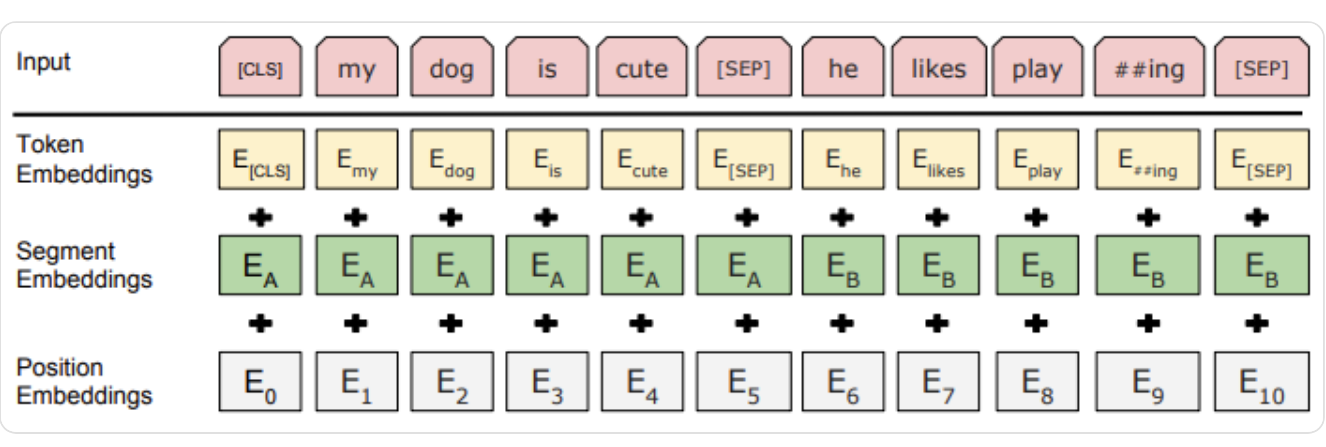

In [36]:
# 몇가지 유틸리티 함수 정의

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = (tokens == i_pad).float()
    mask = mask.unsqueeze(1)
    return mask

def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tokens.size(1)
    ahead_mask = 1 - torch.tril(torch.ones((n_seq, n_seq)))
    ahead_mask = ahead_mask.unsqueeze(0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = torch.maximum(ahead_mask, pad_mask)
    return mask

print("슝=3")

슝=3


In [37]:
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

print("슝=3")

슝=3


Gelu 논문
- chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1606.08415
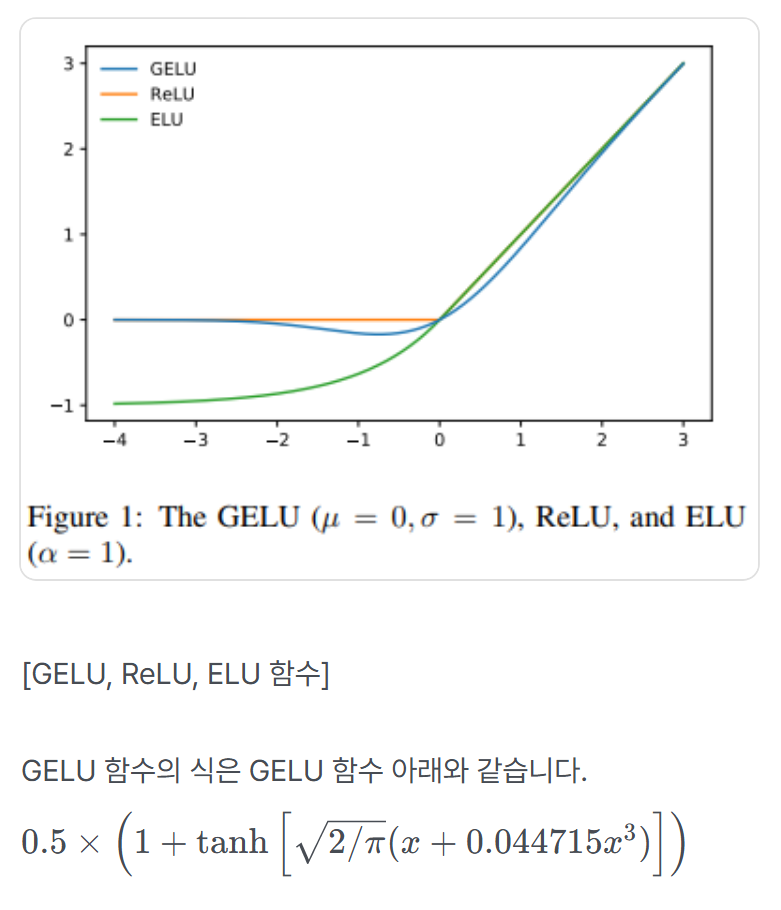

In [38]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return torch.nn.init.trunc_normal_

def bias_initializer():
    """
    bias initializer 생성
    """
    return torch.zeros_

print("슝=3")

슝=3


### 🔶 Embedding layer 쌓기

In [39]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

슝=3


In [40]:
# Token Embedding의 구현

class SharedEmbedding(nn.Module):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        self.shared_weights = nn.Parameter(torch.empty(self.n_vocab, self.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)  # TensorFlow와 동일한 초기화 적용

    def forward(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        inputs = torch.clamp(inputs, max=self.shared_weights.size(0) - 1)

        return self.shared_weights[inputs.long()]

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch, n_seq, _ = inputs.shape
        inputs = inputs.view(-1, self.d_model)  # (bs * n_seq, d_model)
        outputs = torch.matmul(inputs, self.shared_weights.T)
        outputs = outputs.view(n_batch, n_seq, self.n_vocab)  # (bs, n_seq, n_vocab)
        return outputs
print("슝=3")

슝=3


Position Embedding 레이어는 다음과 같습니다.

Transformer이 사인 함수와 코사인 함수를 이용한 Positional Encoding을 통해 토큰의 상대적인 위치를 학습했던 것과 달리, BERT에서는 Position Embedding을 사용합니다. Position Embedding은 위치 정보가 담긴 임베딩 레이어를 하나 더 사용해 Position Embedding 벡터를 학습시켜서, BERT의 입력에 Position Embedding을 더해줍니다

In [41]:
# Positional Embedding layer

class PositionEmbedding(nn.Module):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = torch.cumsum(torch.ones_like(inputs), dim=1) - 1
        position = position.long()
        embed = self.embedding(position)
        return embed

print("슝=3")

슝=3


상대적으로 매우 간단한 Segment Embedding은 별도의 레이어를 구현하지 않고 BERT 클래스에서 간단히 포함하도록 하겠습니다. 
- Segment Embedding는 두 개의 문장을 구분하기 위한 임베딩


In [42]:
# ScaleDotProductAttention

class ScaleDotProductAttention(nn.Module):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

    def forward(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = torch.matmul(Q, K.transpose(-2, -1))
        scale = torch.sqrt(torch.tensor(K.shape[-1], dtype=torch.float32))
        attn_scale = attn_score / scale
        attn_scale = attn_scale - (attn_mask * 1e9)
        attn_prob = F.softmax(attn_scale, dim=-1)
        attn_out = torch.matmul(attn_prob, V)
        return attn_out

print("슝=3")

슝=3


In [43]:
# Multihead Attention

# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(nn.Module):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention()
        # output dense layer
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        batch_size = Q.shape[0]

        # reshape Q, K, V, attn_mask
        Q_m = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        K_m = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        V_m = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        attn_mask_m = attn_mask.unsqueeze(1)

        # Scale Dot Product Attention 실행
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # (batch_size, n_seq, n_head, d_head)로 변환 후, (batch_size, n_seq, d_model)로 reshape
        attn_out_m = attn_out.transpose(1, 2).contiguous()  # (batch_size, n_seq, n_head, d_head)
        attn_out = attn_out_m.view(batch_size, -1, self.n_head * self.d_head)  # (batch_size, n_seq, d_model)
        attn_out = self.W_O(attn_out)  # (batch_size, n_seq, d_model)

        return attn_out
print("슝=3")

슝=3


In [44]:
# Position Wise FFN

class PositionWiseFeedForward(nn.Module):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)

        self.gelu = nn.GELU()

    def forward(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.gelu(self.W_1(inputs)))
        return ff_val

print("슝=3")

슝=3


In [45]:
# transformer Encoder Layer

class EncoderLayer(nn.Module):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

print("슝=3")

슝=3


In [46]:
# 최종적으로 구성할 BERT 레이어

class BERT(nn.Module):
    """
    BERT Class
    """
    def __init__(self, config):
        """
        생성자
        :param config: Config 객체
        """
        super(BERT, self).__init__()

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = nn.Embedding(2, config.d_model)  # Segment embedding layer
        self.norm = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.encoder_layers = nn.ModuleList([EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: 입력 token들
        :param segments: 입력 segment들
        :return logits_cls: CLS 토큰에 대한 예측
        :return logits_lm: Masked Language Modeling 예측
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)

        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:, 0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

print("슝=3")

슝=3


In [47]:
# BERT 레이어를 바탕으로 최종적으로 만들어질 pretrain용 BERT 모델 구성

# Encoder Layer class 정의
class PooledOutput(nn.Module):
    def __init__(self, config, n_output, name="pooled_output"):
        super(PooledOutput, self).__init__()

        self.dense1 = nn.Linear(config.d_model, config.d_model)
        self.dense2 = nn.Linear(config.d_model, n_output, bias=False)

    def forward(self, inputs):
        """
        forward pass
        :param inputs: 모델의 출력 (예: logits_cls)
        :return: softmax된 결과
        """
        outputs = F.tanh(self.dense1(inputs))
        outputs = self.dense2(outputs)
        outputs = F.softmax(outputs, dim=-1)
        return outputs

print("슝=3")

슝=3


In [48]:
class PreTrainModel(nn.Module):
    def __init__(self, config):
        super(PreTrainModel, self).__init__()
        self.bert = BERT(config)
        self.pooled_output = PooledOutput(config, 2)

    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments = segments.long()

        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        logits_cls = self.pooled_output(logits_cls)
        outputs_nsp = F.softmax(logits_cls, dim=-1)

        outputs_mlm = F.softmax(logits_lm, dim=-1)
        return outputs_nsp, outputs_mlm

def build_model_pre_train(config):
    return PreTrainModel(config)

print("슝=3")

n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

슝=3


NameError: name 'config' is not defined

In [49]:
# Base model
# 아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 1024,
    "layernorm_epsilon": 0.001,
    "n_layer": 3,
    "n_seq": 256,
    "n_vocab": 5000,
    "i_pad": 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

In [50]:
n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [51]:
# 모델 불러오기
model = build_model_pre_train(config)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()
        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_batch.view(-1))
        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()

        total_loss_batch.backward()

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}")

Epoch 1/10 - Loss: 9.22644567489624
Epoch 2/10 - Loss: 9.214475154876709
Epoch 3/10 - Loss: 9.205514907836914
Epoch 4/10 - Loss: 9.193882465362549
Epoch 5/10 - Loss: 9.209808826446533
Epoch 6/10 - Loss: 9.199100017547607
Epoch 7/10 - Loss: 9.203545570373535
Epoch 8/10 - Loss: 9.198808670043945
Epoch 9/10 - Loss: 9.192910194396973
Epoch 10/10 - Loss: 9.18533992767334


# 4. pretrain 진행
loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.


loss와 accuracy같이 기본적으로 필요한 계산 함수를 미리 정의해 둡시다. 학습 데이터의 label이 정수로 변환되었으므로 loss 함수는 SparseCategoricalCrossentropy와 동일한 역할을 수행하는 F.cross_entropy를 사용합니다. MLM task에 대해 더 잘 학습하도록 loss를 20배 증가시켜 줍니다.

In [52]:
# loss, accuracy 함수를 정의

# loss함수를 정의

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴

print("슝=3")

# accuracy 함수를 정의

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy

print("슝=3")

슝=3
슝=3


Learning Rate 스케줄링도 아래와 같이 구현합니다. WarmUp 이후 consine 형태로 감소하는 스케줄을 적용합니다.

최근에는 Learning Rate를 단순히 감소시키기 보다는 진동하면서 최적점을 찾아가는 방식을 많이 사용하고 있습니다. 다양한 방법을 찾아서 적용시켜 보는 것도 성능을 높이는 좋은 방법입니다.

In [53]:
# Learning Rate 스케줄링

class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

print("슝=3")

슝=3


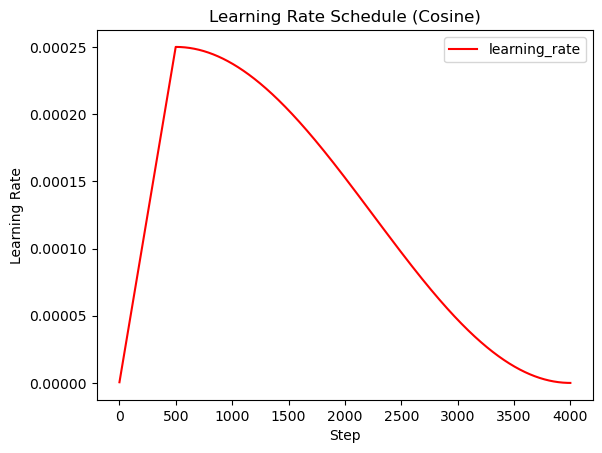

In [54]:
# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

In [55]:
# 이제 모델을 실제로 빌드해 봅시다.

In [56]:
# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 128]                 --
│    └─SharedEmbedding: 2-1                                  [10, 128, 128]            640,000
│    └─PositionEmbedding: 2-2                                [10, 128, 128]            --
│    │    └─Embedding: 3-1                                   [10, 128, 128]            16,384
│    └─Embedding: 2-3                                        [10, 128, 128]            256
│    └─LayerNorm: 2-4                                        [10, 128, 128]            256
│    └─Dropout: 2-5                                          [10, 128, 128]            --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 128]         

이제 본격적으로 학습을 진행합니다. 1 Epoch만 학습하는 데도 10분 이상의 상당한 시간이 소요될 것입니다. 메모리 오류가 날 수 있으니 배치 사이즈에도 유의해 주세요. 우리는 전체 데이터셋 중의 1/7 수준인 128,000건만 로딩해서 사용 중이라는 것을 기억합시다.

optimizer는 Adam을 사용하고, MLM과 NSP에 대한 loss와 accuracy를 알 수 있도록 하였습니다.

In [57]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

train_steps: 20000


In [58]:
# 학습시킨 모델을 콜백 함수를 사용해 저장하고, 시각화해 봅시다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

'''
<수정전>

pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]
'''

# <수정후>
# 이미 텐서라면 그대로 두고(device만 이동), 아니라면 변환 후 이동
pre_train_inputs = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

pre_train_model.to(device)

history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(pre_train_model.state_dict(), f"{"/home/jovyan/work/bert_pretrain/models"}/bert_pre_train_epoch_{epoch+1}.pt")


Epoch 1/10 - Loss: 8.421864151477815, NSP Loss: 0.6618442069292069, MLM Loss: 7.760019944906235, NSP Accuracy: 0.598328125, MLM Accuracy: 0.8272533569335937
Epoch 2/10 - Loss: 8.307658281326294, NSP Loss: 0.6590623519718647, MLM Loss: 7.648595932245255, NSP Accuracy: 0.59909375, MLM Accuracy: 0.8693134765625
Epoch 3/10 - Loss: 8.306142455101012, NSP Loss: 0.6577581306397915, MLM Loss: 7.6483843271732335, NSP Accuracy: 0.5956953125, MLM Accuracy: 0.869313232421875
Epoch 4/10 - Loss: 8.305544642448424, NSP Loss: 0.6572483084797859, MLM Loss: 7.64829633307457, NSP Accuracy: 0.595921875, MLM Accuracy: 0.8693134765625
Epoch 5/10 - Loss: 8.305377315044403, NSP Loss: 0.6571104897856712, MLM Loss: 7.648266830921173, NSP Accuracy: 0.5984609375, MLM Accuracy: 0.8693134765625
Epoch 6/10 - Loss: 8.30498792219162, NSP Loss: 0.6567341035604477, MLM Loss: 7.6482538318634035, NSP Accuracy: 0.6000859375, MLM Accuracy: 0.8693134765625
Epoch 7/10 - Loss: 8.304566029071808, NSP Loss: 0.6563217189908027, M

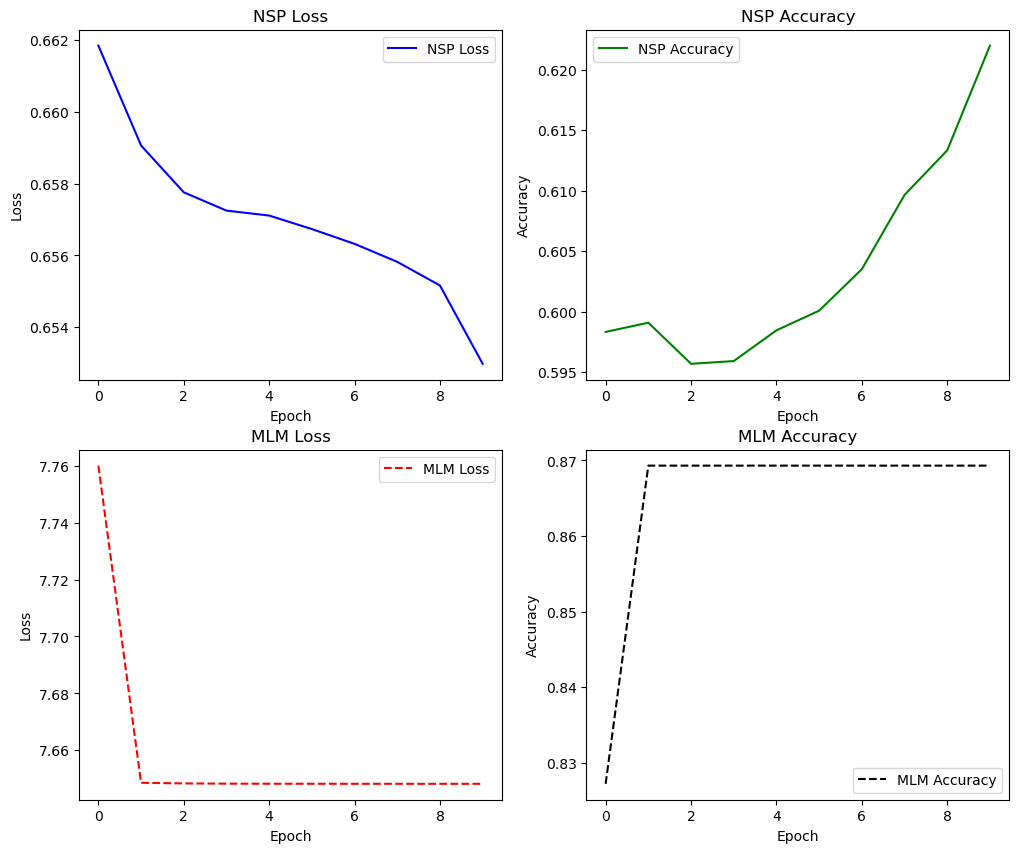

In [59]:

# training result
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("NSP Loss")
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("NSP Accuracy")
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.title("MLM Loss")
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.title("MLM Accuracy")
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 

# 5. 프로젝트 결과
학습된 모델과 학습과정을 시각화해 보세요. NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.

### 5.1. 타겟: 100만 이하 파라미터 찾기

파라미터를 100만이하로 줄이면서도 성능을 최대한 지키는 것은 까다로운 트레이드 오프이다.

각 파라미터를 줄였을때 성능과 속도에 미치는 영향을 아래와 같이 정리하고 이를 바탕으로 최적의 타협점을 찾고자 한다

1. hidden_size 조절(현재 128 ->64)
   - 모델이 정보를 이해하는 지능의 폭
   - 성능:size를 줄일 경우 성능은 나빠진다. 문장의 복잡한 의미나 단어 간의 미묘한 관계를 담을 공간(벡터 차원)이 부족해져 정확도가 급격히 떨어질 수 있다.
   - 속도: 파라미터 수가 제곱으로 줄어들기 때문에 모델 용량은 확줄지만 연산 병렬화 효율 때문에 속도 향상은 리니어하게 느껴질수 있다.
   - 전략: 최후의 수단, 128 밑으로 내리면 성능 방어가 어렵다

2. num_hidden layers 레이어수 조절(현재 3층 ->2층)
   - 정보를 얼마나 깊게 추론할지 결정하는 지능의 깊이
   - 성능: 추론 능력이 단순해지고 다단계 논리 해결 능력이 떨어진다. 하지만 단순 분류문제에는 타격이 없다
   - 속도: 층을 덜 거치면 연산량도 1/3 줄어들기에 학습과 추론 속도가 비약적으로 빨라진다
   - 전략: 복잡한 자연어 추론이 아닌 이상 2-3개 층으로도 꽤 괜찮은 성능을 낸다
     
3.  중간 레이어 크기(intermediate_size)조절
   - 각층 내부에서 데이터르 뻥튀기해서 분석하는 분석용 작업대 크기이다 보통 hiddensize의 4배이다
   - 성능: 모델의 기억용량이나 특징 추출 능력이 약간 감소하지만 hiddensize를 줄이는 것보다 성능저하가 덜하다
   - 속도: 파라미터 수르 꽤많이 줄여주면서 연산속도가 빨라진다
   - 전략: 가성비가 좋다. 성능 손실 대비 파라미터 감소 효과가 좋다

4. d_ff(Feed forward 크기)줄이기(현재 1024 ->512,256)
   - 보통 bert구조에서 d_ff는 d_model의 4배로 설정하는것이 국룰이다. 현재 d_model이 128인데 d_ff가 1024이므로 8배나 크다. 불필요한 파라미터가 있다.

5. d_head(head크기) 최적화(현재 64 ->32)
   - bert에서는 보통 n_head * d_head =d_model이 되도록 설계함 현재 4*64=256은 d_model 128보다 크다. 즉 어텐션 연산 중에 차원을 억지로 2배 하고 있다.

### 5.2. 실험 1

test1 : d_ff 1024->256으로 줄이기


In [61]:
# 아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "d_ff": 256,
    "layernorm_epsilon": 0.001,
    "n_layer": 3,
    "n_seq": 256,
    "n_vocab": 5000,
    "i_pad": 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 불러오기
model = build_model_pre_train(config)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()
        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_batch.view(-1))
        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()

        total_loss_batch.backward()

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}")

Epoch 1/10 - Loss: 9.216774940490723
Epoch 2/10 - Loss: 9.199520111083984
Epoch 3/10 - Loss: 9.190775871276855
Epoch 4/10 - Loss: 9.180659294128418
Epoch 5/10 - Loss: 9.182888507843018
Epoch 6/10 - Loss: 9.176434993743896
Epoch 7/10 - Loss: 9.163495540618896
Epoch 8/10 - Loss: 9.162035942077637
Epoch 9/10 - Loss: 9.160524845123291
Epoch 10/10 - Loss: 9.160725116729736


슝=3
슝=3
슝=3


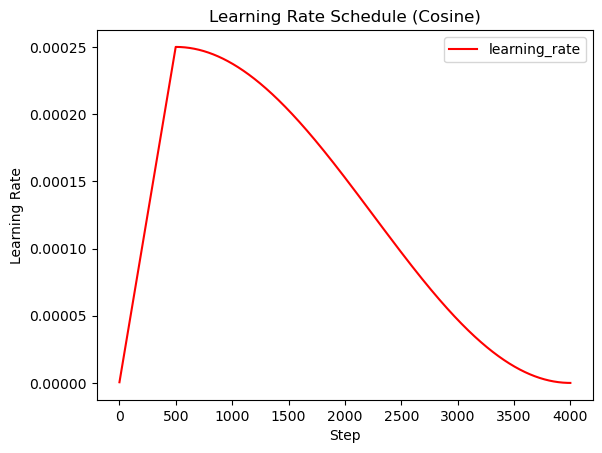

train_steps: 20000
Epoch 1/10 - Loss: 8.422539756298065, NSP Loss: 0.6621079279184341, MLM Loss: 7.760431827783584, NSP Accuracy: 0.5966015625, MLM Accuracy: 0.8273165893554687
Epoch 2/10 - Loss: 8.307553808689118, NSP Loss: 0.6589733050167561, MLM Loss: 7.648580507516861, NSP Accuracy: 0.597890625, MLM Accuracy: 0.8693134765625
Epoch 3/10 - Loss: 8.306066444396972, NSP Loss: 0.6577057036757469, MLM Loss: 7.648360749959946, NSP Accuracy: 0.5975, MLM Accuracy: 0.8693134765625
Epoch 4/10 - Loss: 8.305537707805634, NSP Loss: 0.6572374829649925, MLM Loss: 7.648300222158432, NSP Accuracy: 0.59915625, MLM Accuracy: 0.8693134765625
Epoch 5/10 - Loss: 8.30513301038742, NSP Loss: 0.6568614695966244, MLM Loss: 7.648271538019181, NSP Accuracy: 0.6007421875, MLM Accuracy: 0.8693134765625
Epoch 6/10 - Loss: 8.303485489845276, NSP Loss: 0.6552312727868557, MLM Loss: 7.64825422167778, NSP Accuracy: 0.6091953125, MLM Accuracy: 0.8693134765625
Epoch 7/10 - Loss: 8.300776966571808, NSP Loss: 0.652530728

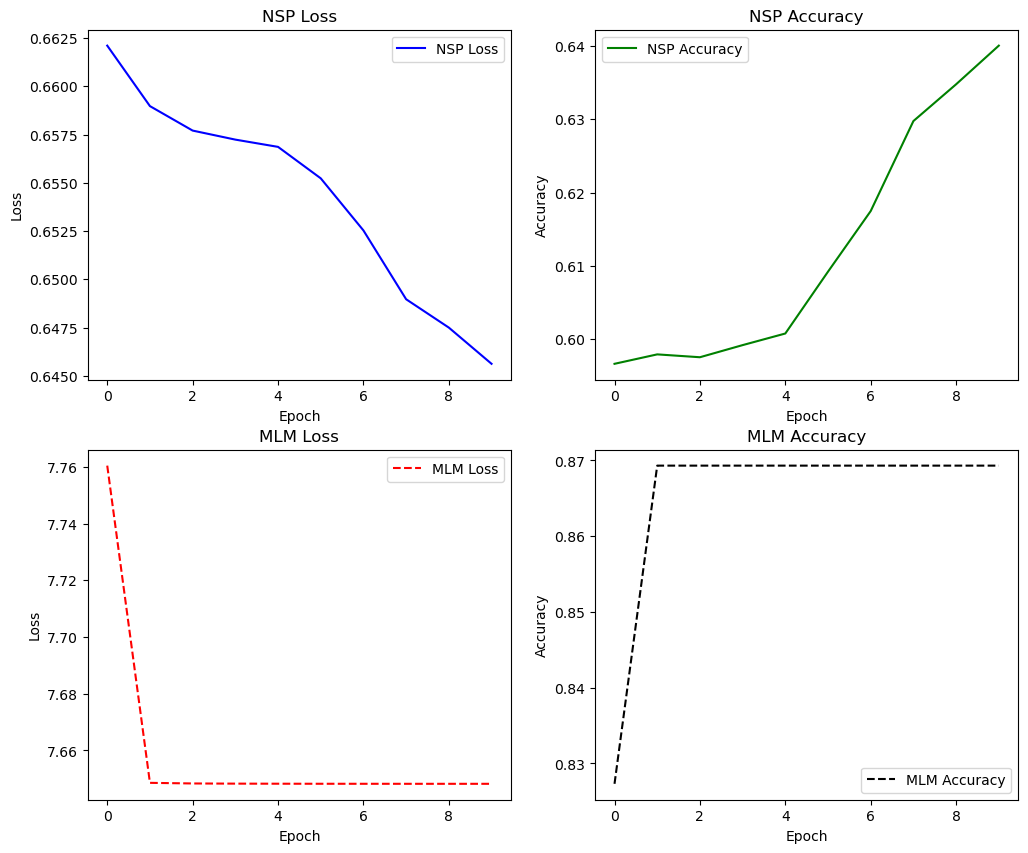

In [62]:
# loss, accuracy 함수를 정의

# loss함수를 정의

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴

print("슝=3")

# accuracy 함수를 정의

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy

print("슝=3")

# Learning Rate 스케줄링

class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

print("슝=3")

# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

# 학습시킨 모델을 콜백 함수를 사용해 저장하고, 시각화해 봅시다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

'''
<수정전>

pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]
'''

# <수정후>
# 이미 텐서라면 그대로 두고(device만 이동), 아니라면 변환 후 이동
pre_train_inputs = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

pre_train_model.to(device)

history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(pre_train_model.state_dict(), f"{"/home/jovyan/work/bert_pretrain/models"}/bert_pre_train_epoch_{epoch+1}.pt")


# training result
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("NSP Loss")
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("NSP Accuracy")
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.title("MLM Loss")
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.title("MLM Accuracy")
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 


In [63]:
# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 128]                 --
│    └─SharedEmbedding: 2-1                                  [10, 128, 128]            640,000
│    └─PositionEmbedding: 2-2                                [10, 128, 128]            --
│    │    └─Embedding: 3-1                                   [10, 128, 128]            16,384
│    └─Embedding: 2-3                                        [10, 128, 128]            256
│    └─LayerNorm: 2-4                                        [10, 128, 128]            256
│    └─Dropout: 2-5                                          [10, 128, 128]            --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 128]         

## 실험 1 결과

d_ff->256으로 줄임

결과
파라미터수 180만-> 126만   파라미터수 줄어듬
NSP Loss  0.65 -> 0.66   조금 증가했으나 큰 차이 없음
MLM Loss  7.64 -> 7.64   변동 없음

### 5.3. 실험 2

test2 : d_ff 1024->256으로 줄이기, d_head 64-> 32로 줄이기

In [65]:
# 아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 32,
    "dropout": 0.1,
    "d_ff": 256,
    "layernorm_epsilon": 0.001,
    "n_layer": 3,
    "n_seq": 256,
    "n_vocab": 5000,
    "i_pad": 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 불러오기
model = build_model_pre_train(config)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()
        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_batch.view(-1))
        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()

        total_loss_batch.backward()

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}")

Epoch 1/10 - Loss: 9.219455242156982
Epoch 2/10 - Loss: 9.20111608505249
Epoch 3/10 - Loss: 9.181694507598877
Epoch 4/10 - Loss: 9.175819873809814
Epoch 5/10 - Loss: 9.17165994644165
Epoch 6/10 - Loss: 9.164721965789795
Epoch 7/10 - Loss: 9.161404609680176
Epoch 8/10 - Loss: 9.153607845306396
Epoch 9/10 - Loss: 9.153906345367432
Epoch 10/10 - Loss: 9.152931213378906


슝=3
슝=3
슝=3


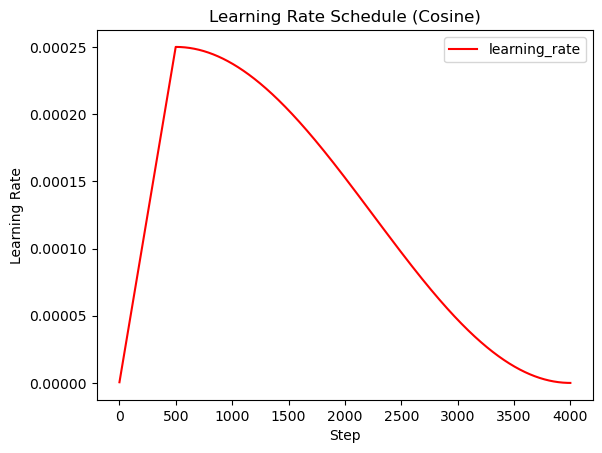

train_steps: 20000
Epoch 3/10 - Loss: 8.30621591758728, NSP Loss: 0.6578616932928563, MLM Loss: 7.648354224920273, NSP Accuracy: 0.5971796875, MLM Accuracy: 0.8693134765625
Epoch 4/10 - Loss: 8.305462330818177, NSP Loss: 0.6571684020757675, MLM Loss: 7.648293929338455, NSP Accuracy: 0.597359375, MLM Accuracy: 0.8693134765625
Epoch 5/10 - Loss: 8.305297379016876, NSP Loss: 0.6570282342135906, MLM Loss: 7.648269146203995, NSP Accuracy: 0.6000703125, MLM Accuracy: 0.8693134765625
Epoch 6/10 - Loss: 8.304661839962005, NSP Loss: 0.6564096142947674, MLM Loss: 7.648252217531204, NSP Accuracy: 0.6026484375, MLM Accuracy: 0.8693134765625
Epoch 7/10 - Loss: 8.303882054805756, NSP Loss: 0.6556378026008606, MLM Loss: 7.648244244337082, NSP Accuracy: 0.6080234375, MLM Accuracy: 0.8693134765625
Epoch 8/10 - Loss: 8.302079758167267, NSP Loss: 0.6538390835225583, MLM Loss: 7.648240677118301, NSP Accuracy: 0.6132421875, MLM Accuracy: 0.8693134765625
Epoch 9/10 - Loss: 8.299566964149475, NSP Loss: 0.651

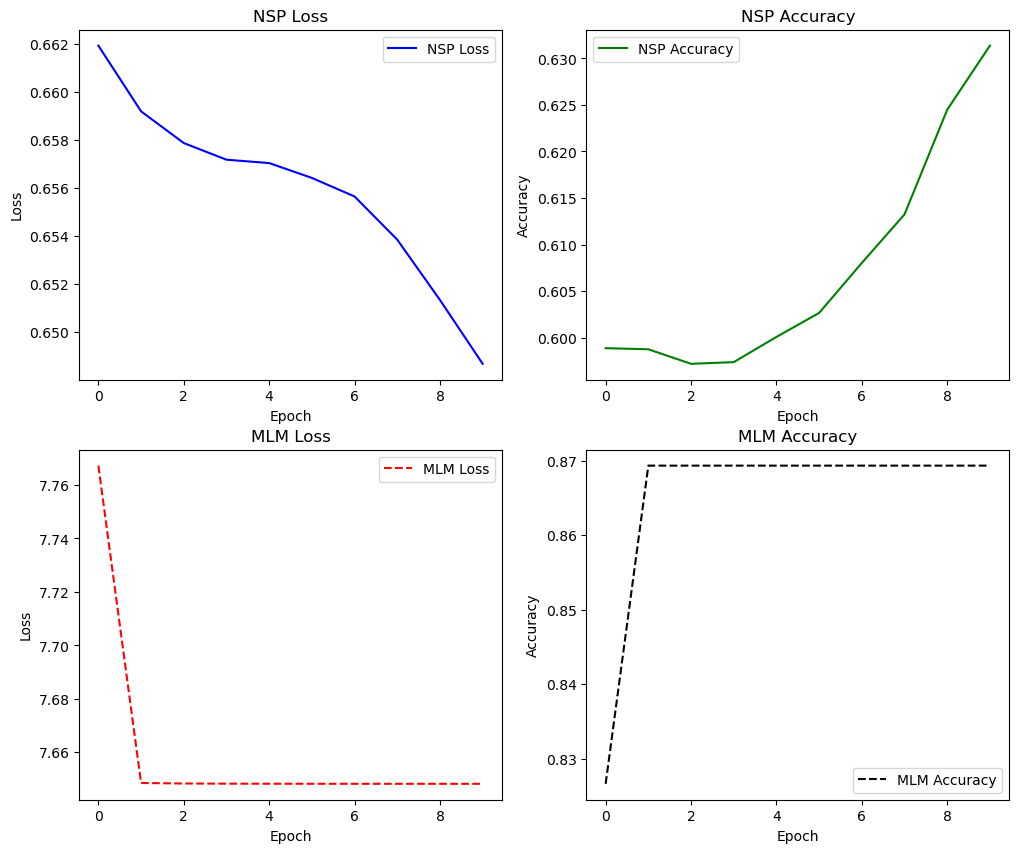

In [66]:
# loss, accuracy 함수를 정의

# loss함수를 정의

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴

print("슝=3")

# accuracy 함수를 정의

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy

print("슝=3")

# Learning Rate 스케줄링

class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

print("슝=3")

# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

# 학습시킨 모델을 콜백 함수를 사용해 저장하고, 시각화해 봅시다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

'''
<수정전>

pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]
'''

# <수정후>
# 이미 텐서라면 그대로 두고(device만 이동), 아니라면 변환 후 이동
pre_train_inputs = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

pre_train_model.to(device)

history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(pre_train_model.state_dict(), f"{"/home/jovyan/work/bert_pretrain/models"}/bert_pre_train_epoch_{epoch+1}.pt")


# training result
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("NSP Loss")
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("NSP Accuracy")
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.title("MLM Loss")
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.title("MLM Accuracy")
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 


In [67]:
# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 128]                 --
│    └─SharedEmbedding: 2-1                                  [10, 128, 128]            640,000
│    └─PositionEmbedding: 2-2                                [10, 128, 128]            --
│    │    └─Embedding: 3-1                                   [10, 128, 128]            16,384
│    └─Embedding: 2-3                                        [10, 128, 128]            256
│    └─LayerNorm: 2-4                                        [10, 128, 128]            256
│    └─Dropout: 2-5                                          [10, 128, 128]            --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 128]         

### 5.4. 실험 3

test2 : d_ff 1024->256으로 줄이기, 
d_head 64-> 32로 줄이기, 
layer 줄이기 3->2

In [68]:
# 아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 32,
    "dropout": 0.1,
    "d_ff": 256,
    "layernorm_epsilon": 0.001,
    "n_layer": 2,
    "n_seq": 256,
    "n_vocab": 5000,
    "i_pad": 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 불러오기
model = build_model_pre_train(config)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()
        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_batch.view(-1))
        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()

        total_loss_batch.backward()

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}")

Epoch 1/10 - Loss: 9.204970359802246
Epoch 2/10 - Loss: 9.160783290863037
Epoch 3/10 - Loss: 9.130295276641846
Epoch 4/10 - Loss: 9.118748188018799
Epoch 5/10 - Loss: 9.107024192810059
Epoch 6/10 - Loss: 9.093510150909424
Epoch 7/10 - Loss: 9.085021495819092
Epoch 8/10 - Loss: 9.07524585723877
Epoch 9/10 - Loss: 9.072563648223877
Epoch 10/10 - Loss: 9.067009449005127


슝=3
슝=3
슝=3


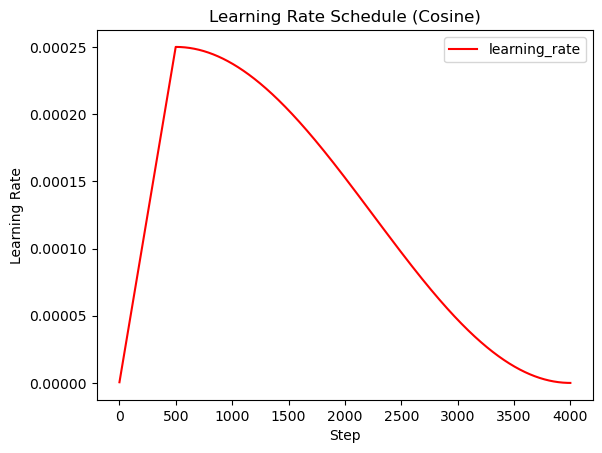

train_steps: 20000
Epoch 1/10 - Loss: 8.423418386936188, NSP Loss: 0.6624578773379326, MLM Loss: 7.760960508823395, NSP Accuracy: 0.595203125, MLM Accuracy: 0.82303955078125
Epoch 2/10 - Loss: 8.308045097351075, NSP Loss: 0.6595181185007095, MLM Loss: 7.64852698802948, NSP Accuracy: 0.598640625, MLM Accuracy: 0.8693134765625
Epoch 3/10 - Loss: 8.306550426483154, NSP Loss: 0.6582000570595264, MLM Loss: 7.648350368976593, NSP Accuracy: 0.5995390625, MLM Accuracy: 0.8693134765625
Epoch 4/10 - Loss: 8.305598511695862, NSP Loss: 0.6572974585294723, MLM Loss: 7.648301044940949, NSP Accuracy: 0.598984375, MLM Accuracy: 0.8693131713867187
Epoch 5/10 - Loss: 8.30482133769989, NSP Loss: 0.6565507836639881, MLM Loss: 7.648270558118821, NSP Accuracy: 0.6011640625, MLM Accuracy: 0.8693134765625
Epoch 6/10 - Loss: 8.303310015201568, NSP Loss: 0.6550577660799026, MLM Loss: 7.648252239465713, NSP Accuracy: 0.609453125, MLM Accuracy: 0.8693134765625
Epoch 7/10 - Loss: 8.30142014503479, NSP Loss: 0.6531

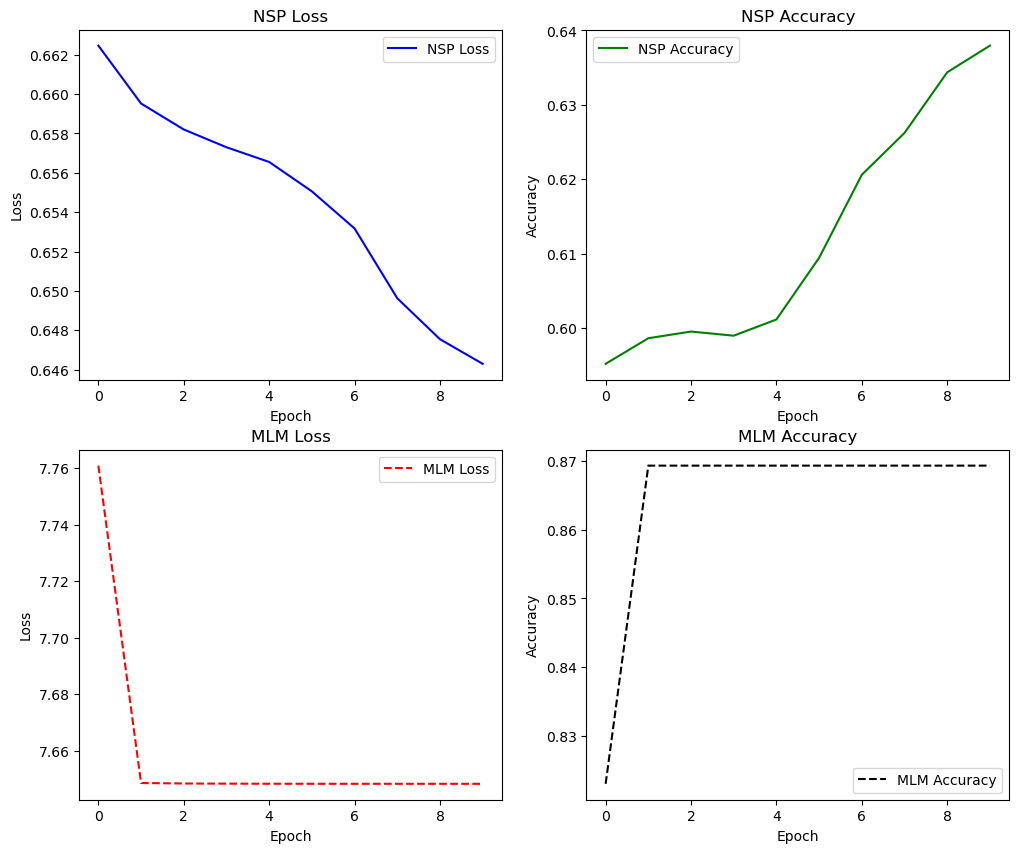

In [69]:
# loss, accuracy 함수를 정의

# loss함수를 정의

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴

print("슝=3")

# accuracy 함수를 정의

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy

print("슝=3")

# Learning Rate 스케줄링

class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

print("슝=3")

# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

# 학습시킨 모델을 콜백 함수를 사용해 저장하고, 시각화해 봅시다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

'''
<수정전>

pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]
'''

# <수정후>
# 이미 텐서라면 그대로 두고(device만 이동), 아니라면 변환 후 이동
pre_train_inputs = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

pre_train_model.to(device)

history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(pre_train_model.state_dict(), f"{"/home/jovyan/work/bert_pretrain/models"}/bert_pre_train_epoch_{epoch+1}.pt")


# training result
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("NSP Loss")
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("NSP Accuracy")
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.title("MLM Loss")
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.title("MLM Accuracy")
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 


In [70]:
# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 128]                 --
│    └─SharedEmbedding: 2-1                                  [10, 128, 128]            640,000
│    └─PositionEmbedding: 2-2                                [10, 128, 128]            --
│    │    └─Embedding: 3-1                                   [10, 128, 128]            16,384
│    └─Embedding: 2-3                                        [10, 128, 128]            256
│    └─LayerNorm: 2-4                                        [10, 128, 128]            256
│    └─Dropout: 2-5                                          [10, 128, 128]            --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 128]         

### 5.5. 실험 4. 전체 데이터 사용
기존 테스트 부분 128000건 사용-> 실험 4 전체 3857761건 사용

In [34]:
# 전체 데이터 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=None)

  0%|          | 0/918189 [00:00<?, ?it/s]

In [35]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5, 3629,  203,    6,    6, 1114, 3724,  788,  243,   49, 3632,
          796,  663, 1647, 3682, 3682, 3625,    6, 3008, 3625, 3616,   16,
         3599,   18, 3686,  207, 3714, 3602,    6,    6,    6,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624, 1135,   52, 3599,   13,   81,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,   14, 1509,  168, 3877,  414,  165, 1697, 4290, 3873,
         3703, 3683,    6,   21, 5007,  399,    6,    6,    6,    6,    6,
          307,  587,  931,  103, 4313, 4290,  613, 3638, 3718,   98, 3878,
         3656,  256, 2543,  309,  337, 3735,  181, 3616, 3603,    6,    6,
            6,    4,   18, 3686,  207, 3714,    4], dtype=int32),
 memmap([   5,   55, 3674, 3689,    4,   55, 3674, 2149,  356, 4039,  635,
          809, 3665,   46, 4331, 3

In [49]:
# 아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 128,
    "n_head": 4,
    "d_head": 32,
    "dropout": 0.1,
    "d_ff": 256,
    "layernorm_epsilon": 0.001,
    "n_layer": 2,
    "n_seq": 256,
    "n_vocab": 5000,
    "i_pad": 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

n_seq = 10

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 5
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 모델 불러오기
model = build_model_pre_train(config)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()
        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)
        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, config.n_vocab), labels_mlm_batch.view(-1))
        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()

        total_loss_batch.backward()

        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}")

Epoch 1/10 - Loss: 9.215030193328857
Epoch 2/10 - Loss: 9.194117069244385
Epoch 3/10 - Loss: 9.194380760192871
Epoch 4/10 - Loss: 9.180553436279297
Epoch 5/10 - Loss: 9.177976608276367
Epoch 6/10 - Loss: 9.17487907409668
Epoch 7/10 - Loss: 9.170076370239258
Epoch 8/10 - Loss: 9.170701503753662
Epoch 9/10 - Loss: 9.153370380401611
Epoch 10/10 - Loss: 9.15723991394043


슝=3
슝=3
슝=3


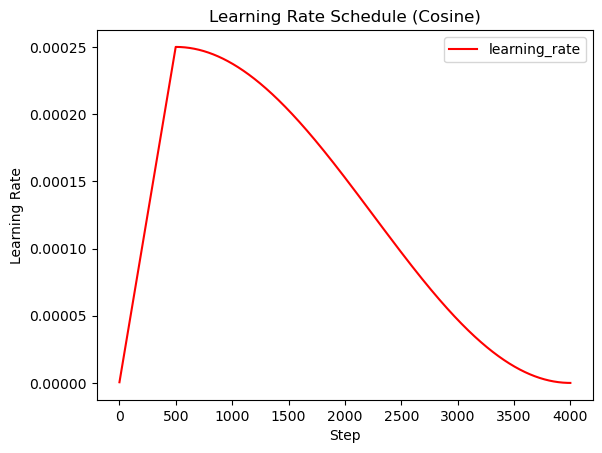

train_steps: 143470
Epoch 1/10 - Loss: 8.258454175978212, NSP Loss: 0.6084603634189378, MLM Loss: 7.649993815454962, NSP Accuracy: 0.7261061400762957, MLM Accuracy: 0.8781988389144553
Epoch 2/10 - Loss: 8.226405386693088, NSP Loss: 0.5957172134117507, MLM Loss: 7.630688173410127, NSP Accuracy: 0.7535689565382112, MLM Accuracy: 0.886863034664899
Epoch 3/10 - Loss: 8.224280389732723, NSP Loss: 0.5935932298342077, MLM Loss: 7.630687160808351, NSP Accuracy: 0.7586960446637641, MLM Accuracy: 0.8868634612201157
Epoch 4/10 - Loss: 8.222703082209025, NSP Loss: 0.5920154925230913, MLM Loss: 7.630687590649778, NSP Accuracy: 0.762726092563736, MLM Accuracy: 0.8868630539500988
Epoch 5/10 - Loss: 8.221771246349803, NSP Loss: 0.5910837486860951, MLM Loss: 7.630687494331797, NSP Accuracy: 0.7653903158240978, MLM Accuracy: 0.8868630826909459
Epoch 6/10 - Loss: 8.22106927750858, NSP Loss: 0.5903819509314321, MLM Loss: 7.630687326190778, NSP Accuracy: 0.7671508464803594, MLM Accuracy: 0.8868632313058028

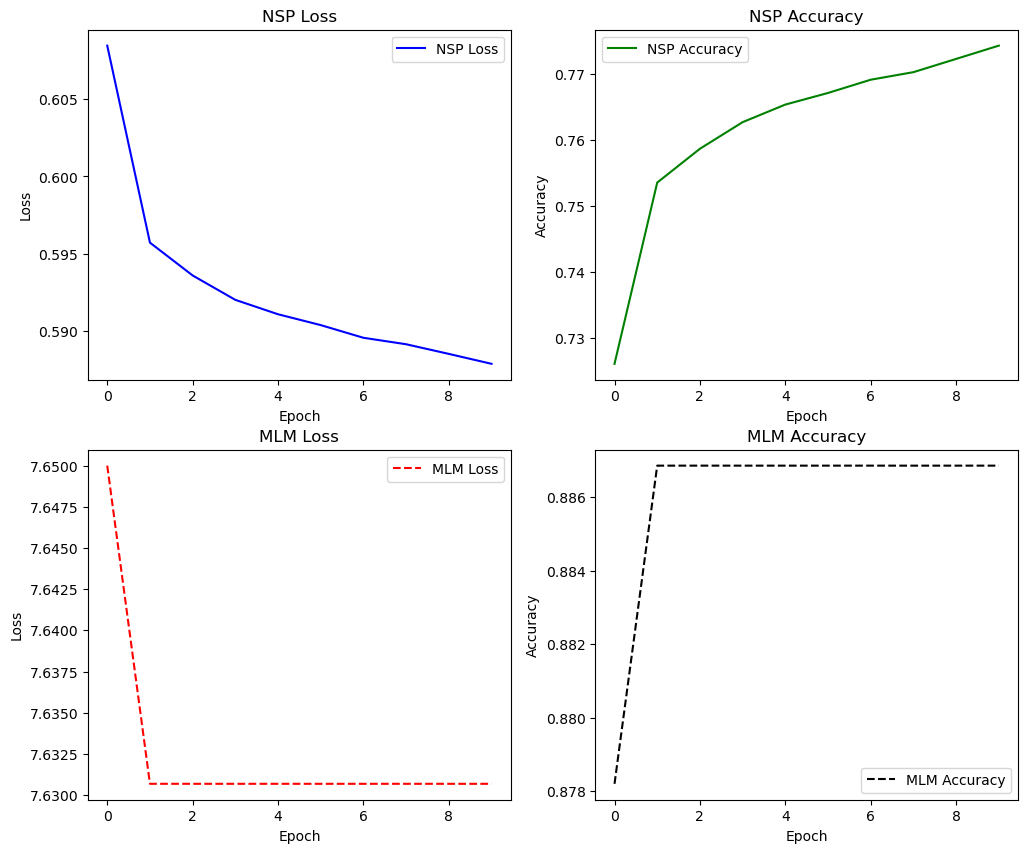

In [50]:
# loss, accuracy 함수를 정의

# loss함수를 정의

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴

print("슝=3")

# accuracy 함수를 정의

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy

print("슝=3")

# Learning Rate 스케줄링

class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()

print("슝=3")

# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

# 모델 생성
from torchinfo import summary

config.n_seq = 128
pre_train_model = build_model_pre_train(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pre_train_model.to(device)

enc_tokens_example = torch.randint(0, config.n_vocab, (10, config.n_seq), dtype=torch.long).to(device)
segments_example = torch.randint(0, 2, (10, config.n_seq), dtype=torch.long).to(device)

summary(pre_train_model, [(10, config.n_seq), (10, config.n_seq)])

epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(pre_train_model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

# 학습시킨 모델을 콜백 함수를 사용해 저장하고, 시각화해 봅시다.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

'''
<수정전>

pre_train_inputs = [torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [torch.tensor(np.array(x)).to(device) for x in pre_train_labels]
'''

# <수정후>
# 이미 텐서라면 그대로 두고(device만 이동), 아니라면 변환 후 이동
pre_train_inputs = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_inputs]
pre_train_labels = [x.to(device) if isinstance(x, torch.Tensor) else torch.tensor(np.array(x)).to(device) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

pre_train_model.to(device)

history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
}

for epoch in range(epochs):
    pre_train_model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = pre_train_model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(pre_train_model.state_dict(), f"{"/home/jovyan/work/bert_pretrain/models"}/bert_pre_train_epoch_{epoch+1}.pt")


# training result
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("NSP Loss")
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("NSP Accuracy")
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.title("MLM Loss")
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.title("MLM Accuracy")
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show() 


### 5.6 테스트 결과

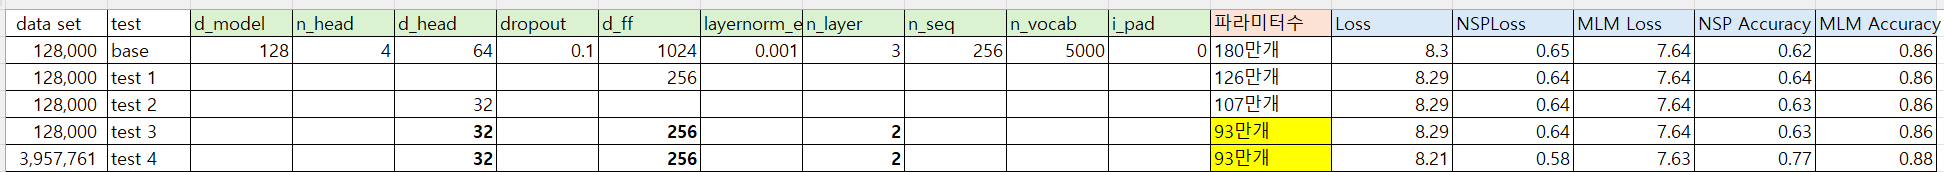

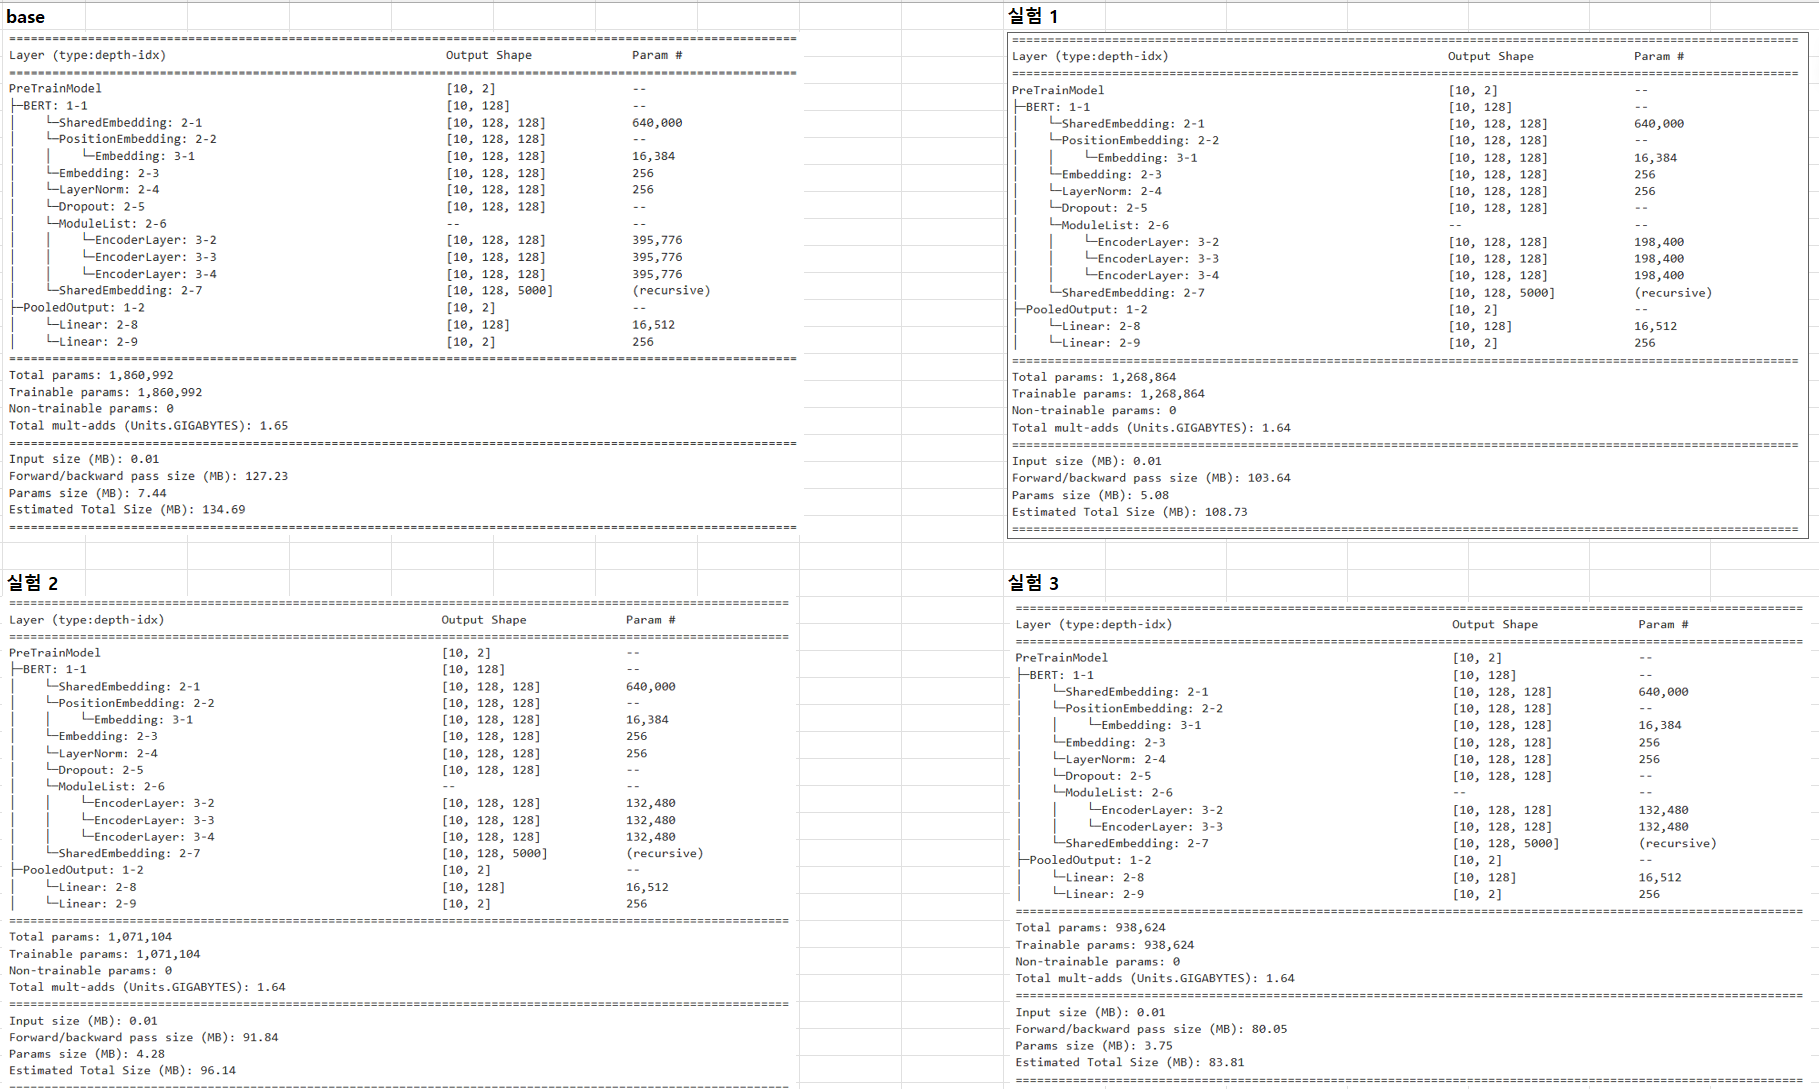

### 5.7 결론

테스트는 순차적으로 feed forward 크기, 헤드 크기(d_head: 64->32), 레이어수(num_hidden layers: 3 ->2) 등 세가지 항목을 줄여보았다. 
테스트 결과 파라미터 수는 베이스모델 186만개에서 최종적으로 100만개 이하인 93만개로  줄어들었다. 각각의 파라미터 수를 보면, feed forward크기(d_ff: 1024->256)를 줄인 경우 126만 개로 줄었고, 헤드 크기를 줄인 경우 107만개로 줄었으며, 레이어수(num_hidden layers: 3 ->2)를 줄인 경우 93만개로 줄었다.

성능은 베이스 모델에서 최종적으로 loss(8.3->8.29), NSP loss(0.65->0.64), MLM loss(7.64->7.64), NSP Accuracy(0.62->0.63), MLM Accuracy(0.86 ->0.86)로 나옴으로써 전체적이 성능이 아주 미세하게 향상되거나 변화하지 않았다.

마지막으로 부분 데이터(128000건)에서 전체 데이터로 바꿔서 모델을 돌린 결과 loss(8.3->8.21), NSP loss(0.65->0.58), MLM loss(7.64->7.63), NSP Accuracy(0.62->0.77), MLM Accuracy(0.86 ->0.88)로 전체적으로 성능이 아주 미세하게 향상되었다.

# 6. 회고


파라미터수가 크면 모델 성능이 당연히 더 좋을 것인라는 인식을 갖고 있었는데, 파라미터 수를 줄여도 성능이 나빠지지 않았다. 
작고 가벼운 모델을 만들기 위해 데이터에 맞게 각 파라미터의 적절한 수를 찾는 것이 필요하겠다는 생각이 들었다.
